# Estimating the Energy Density of a U(1) Lattice Gauge Theory

In [1]:
#Katherine Van Kirk
#kvankirk@g.harvard.edu

# This code works with a U(1) Lattice Gauge Theory of stacked triangular plaquettes. 
# See eqn 4.1 in https://arxiv.org/pdf/2002.10028.pdf 
# Details behind the code implementation may be found in Appendix F. 

In [2]:
# Packages
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import copy
import math
from math import e
import random 
import ast
import time
import scipy.sparse
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse.linalg import svds, eigs
from itertools import permutations
from scipy.stats import unitary_group
from numpy.random import choice
from scipy.linalg import null_space, expm
from scipy.linalg import norm
from scipy.stats import unitary_group
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
import jax
from neural_tangents import stax
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import copy
from os import path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

# Pauli Matrices
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]],dtype=complex)
Z = np.array([[1,0],[0,-1]])

# Helper Functions

### A. Helper Functions for Creating Global Parameters

In [3]:
# DESCRIPTION: Discretize SU(2) by randomly choosing S unitaries from SU(2). Make a big datavector, where each entry
# is a different SU(2) matrix.
def discretize_su2(S):
    unitariesToKeep = []
    for x in range(S):
        V = unitary_group.rvs(2) #U(2)
        unitariesToKeep.append(V)
    return unitariesToKeep

# DESCRIPTION: This function seeds the first unitaries in the global variable set su2nitaries with unitaries we will
# use to define unbiased versions of the operators of interest. 
# LIST OF SEEDED UNITARIES:
#   (0) Z -> X (Hadamard)
#   (1) Z -> (X+Y) / sqrt2
#   (2) Z -> (X-Y) / sqrt2
#   (3) Z -> Z (Identity)
#   (4) Z -> Y
def seedsu2nitaries():
    #create the unitaries that take (1) Z -> X+Y and (2) Z -> X-Y
    H = [[np.cos(math.pi/4),np.sin(math.pi/4)],[-np.sin(math.pi/4),np.cos(math.pi/4)]] #Hadamard
    XYplaneP = [[e ** (0+math.pi*0.125j),0],[0,e ** (0-math.pi*0.125j)]] #45deg rotation CCW
    XYplaneM = [[e ** (0-math.pi*0.125j),0],[0,e ** (0+math.pi*0.125j)]] #45deg rotation CW

    XpY = np.matrix(np.matmul(H,XYplaneP)) #This unitary takes Z -> X+Y
    XmY = np.matrix(np.matmul(H,XYplaneM)) #This unitary takes Z -> X-Y
    
    #create the unitary that takes (4) Z -> Y
    Yplane = [[e ** (0+math.pi*0.25j),0],[0,e ** (0-math.pi*0.25j)]] #90deg rotation CCW
    ZtoY = np.matrix(np.matmul(H,Yplane))#This unitary takes Z -> Y
    
    #Update su2nitaries
    su2nitaries[0]=np.multiply(1/np.sqrt(2),[[1,1],[1,-1]])
    su2nitaries[1]=XpY
    su2nitaries[2]=XmY
    su2nitaries[3]=np.identity(2)
    su2nitaries[4]=ZtoY

# DESCRIPTION: In many cases, we need \ket{b}\bra{b} for all computational basis states b. This function makes a list
# of these for a certain number of qubits n
def makeBBlist(n):
    return [makebbvector(b,n) for b in range(2**n)]

# DESCRIPTION: Just like we have the su2nitaries global variable, we also want a list of the same random su(2) 
# unitaries, but we want them tensored together n times. This function creates two versions of this list: (1) tensored
# n times and (2) hermitian conjugate of tensored n times. 
def tensorVersionSU2nitaries(n):
    tensorn = [np.matrix(tensorntimes(su2nitaries[v],n)) for v in range(len(su2nitaries))]
    tensornH = [tensorntimes(np.matrix(su2nitaries[v]).getH(),n) for v in range(len(su2nitaries))]
    return (tensorn,tensornH)

# DESCRIPTION: Using the global vectors of V \tensor n and \ket{b}\bra{b}, this function creates a vector of all 
# V^\dagger \ket{b}\bra{b} V matrices, and they are indexed according to the convention described at the start of this code 
# block.
def constructVBBVvector():
    VbbVvec = np.matmul(tensornAcrossbH,bsAcrossV) # construct vector of VbbVs
    VbbVvec = np.matmul(VbbVvec,tensornAcrossb)
    return VbbVvec

# DESCRIPTION: Given some single qubit unitary V, tensor together n of them 
def tensorntimes(V,n):
    Vtensorn = V
    for x in range(n-1):  # Kronecker n times
        Vtensorn = np.kron(Vtensorn, V)
    return Vtensorn

# DESCRIPTION: Returns non-sparse density matrix for the \ket{b}\bra{b} state for some b
# b: index of the computational basis state (runs 0 to 2**n-1)
def makebbvector(mmt, n):
    init_state = np.zeros((2**n,2**n))
    init_state[mmt][mmt] = 1
    return init_state


### B. Helper Functions for Adapting the Variance

In [4]:
# DESCRIPTION: This function returns the average K(V,b) value of the vector of k values fed in
def meanKVb(kvector):
    return np.average(kvector)

# DESCRIPTION: This function returns the variance of the K(V,b) values fed in -- this function assumed uniform 
# sampling over the set of unitaries {V} and assumes the state of interest is the maximally mized state.
def varKVb(kvector):
    return np.var(kvector)


# DESCRIPTION: This function returns the optimal PDF given the kvector representation of an operator. The pdf is 
# for V entries, where the probability of seeing V is \gamma(V). However, the results are scaled for all (V,b) entries
# and thus the V probabilities are repeated 2**n times. Note: the index convention for (V,b) is the same as the 
# convention in the rest of this code.
def makeKbasedPDF(kvector, n):
    #Part 1 -- make pdf
    bestksqd = np.multiply(kvector,kvector)
    summedksqd = np.reshape(bestksqd, (len(su2nitaries), 2**n))
    probperV = np.sqrt(np.sum(summedksqd,1)) #not yet normalized
    
    #Part 2 -- normalize pdf
    normalization = np.sum(probperV)
    pdffromk = np.real(np.multiply(1/normalization,probperV))
    
    #Part 3 -- repeat the entries for the various bs associated with each V
    pdffromk = np.repeat(pdffromk,2**n,0)
    
    return pdffromk

# DESCRIPTION: This function returns the new vector "k'" that we want to use when relying on a nonuniform pdf across
# the unitary set. 
# IMPORTANT NOTES: 
#    (1) When you update the pdf, you also need to update the kvector because suddenly your expectation over 
#    unitaries V and comp basis states b is going to be different. Therefore, to maintain the same operator O 
#    yielded by the k vector, the k vector must be updated via the new pdf. 
#    (2) The pdf passed in is assumed to have only the probability of selecitng V from a set {V}. In other words,
#    there is no 1/2**n factor from the probability of choosing a computational basis state, and the
#    probability of seeing some V is assumed to be repeated 2**n times (in order to account for the 2**n k(V,b)s that 
#    will have to be updated in response to changing the pdf. You should pass in the result of function makeKbasedPDF.
def makeKprimefromPDF(pdf, kvector):
    oneoverpdf = [1/x for x in pdf]
    result = np.multiply(oneoverpdf, kvector)
    
    for k in range(len(result)):
        if math.isnan(result[k]):
            result[k] = 0
            
    return np.multiply(1/len(su2nitaries),result)

# DESCRIPTION: This function reconstructs the operator from the vector of k(V,b) entries. The indices follow the
# convention described at the start of this code block. 
# NOTE: This faster version relys on the creation ahead-of-time of large numpy arrays. These are listed in the global
# variable index.
def makeOfromkVb(kvector, n):
    OTilde = 0
    kvecRESHAPED = np.repeat(kvector,2**(2*n),0).reshape(len(kvector),2**n,2**n)
    result = np.multiply(kvecRESHAPED, VbbVvector)
    
    return np.sum(result,0)/len(su2nitaries)

# DESCRIPTION: This function reconstructs the operator from the vector of k(V,b) entries, assuming nonuniform pdf
# is passed in (pdf assumed to be over the set of unitiaries and comp basis states). 
def makeOfromKVb_weighted(kvector, pdf, n):
    OTilde = 0
    consts = np.multiply(kvector,pdf)
    
    kvecRESHAPED = np.repeat(consts,2**(2*n),0).reshape(len(consts),2**n,2**n)
    result = np.multiply(kvecRESHAPED, VbbVvector)
    
    return np.sum(result,0)*2**n

# DESCRIPTION: This function returns the optimal PDF given the kvector representation of an operator. The pdf is 
# for (V,b) entries, where the probability of seeing k(V,b) is \gamma(V) * 1/2**n. Here, \gamma is prob of the unitary
# V and 1/2**n is the probability of seeing b for the maximally mixed state. The index convention for (V,b) is the
# same as the convention in the rest of this code.
def makeVb_fullPDF(pdf, n):
    return (1/2**n) * pdf

# DESCRIPTION: This function returns the average K(V,b) value of the vector of k values fed in, where each k(V,b) has
# a probably pdf(V,b) of being chosen. The pdf array contains these probabilities and is ASSUMED to sum to 1.
def meanKVb_weighted(kvector, pdf):
    avg = np.sum(np.multiply(kvector, pdf))
    return avg / np.sum(pdf)

# DESCRIPTION: This function returns the variance of the K(V,b) values fed in, where each k(V,b) has
# a probably pdf(V,b) of being chosen. The pdf array contains these probabilities and is ASSUMED to sum to 1.
def varKVb_weighted(kvector, pdf):
    vecmean = [meanKVb_weighted(kvector, pdf)]*len(kvector)
    difffrommean = np.abs(np.subtract(kvector, vecmean))
    difffrommean = np.multiply(difffrommean,difffrommean)
    return np.real(np.sum(np.multiply(difffrommean, pdf)))

# DESCRIPTION: This function returns the variance of the K(V,b) values fed in. The variance depends on the state of 
# interest. However, in practice, we don't know what the state is, which is why we're doing tomography to begin with.
# This function returns the maximum variance over all states. 
# --> still assumes uniform distribution
def varKVb_upperbound(kvector):
    #calculate the size of your system based on the passed in k vector
    sys = int(np.log2(len(kvector)/len(su2nitaries)))
    
    makeuniformPDF = np.ones(len(su2nitaries)*2**sys)
    makeuniformPDF = np.multiply(1/(len(su2nitaries)*2**sys), makeuniformPDF)
    return varKVb_weighted_upperbound(kvector, makeuniformPDF)

# DESCRIPTION: Similar to the function above, this function returns the maximum variance over all states. However, 
# this function assumes each k(V,b) has a probably pdf(V,b) of being chosen. The pdf array contains these
# probabilities and is ASSUMED to sum to 1.
def varKVb_weighted_upperbound(kvector, pdf):
    #calculate the size of your system based on the passed in k vector
    sys = int(np.log2(len(kvector)/len(su2nitaries)))
    
    #make kvSquared
    kvSquared = np.multiply(np.abs(kvector),np.abs(kvector))
    
    #loop over the unitaries
    runningVar = 0
    for uni in range(len(su2nitaries)):
        uniindex = uni * 2**sys
        maxbVal = np.max(kvSquared[uniindex: uniindex+2**sys])
        runningVar += pdf[uniindex]*maxbVal*2**sys 
        #included 2**systemsize here^ because want pdf over ONLY the unitaries
        
    return runningVar

# DESCRIPTION: Same as function above, but uses numpy. 
def varKVb_weighted_upperbound2(kvector, pdf):
    #calculate the size of your system based on the passed in k vector
    sys = int(np.log2(len(kvector)/len(su2nitaries)))
    
    #make kvSquared, get max
    kvSquared = np.multiply(np.abs(kvector),np.abs(kvector))
    kvSquared = np.reshape(kvSquared, (len(su2nitaries), 2**sys))
    maxForEachV = np.amax(kvSquared, axis=1)
    maxForEachV = np.repeat(maxForEachV,2**sys)
    
    return np.sum(np.multiply(pdf, maxForEachV))

# DESCRIPTION: This function returns the optimal PDF given the kvector representation of an operator. The pdf is 
# for V entries, where the probability of seeing V is \gamma(V). However, the results are scaled for all (V,b) entries
# and thus the V probabilities are repeated 2**n times. Note: the index convention for (V,b) is the same as the 
# convention in the rest of this code.
def makeKbasedPDF_maxoverstates(kvector, n):
    #Part 1 -- make pdf
    bestksqd = np.multiply(np.abs(kvector),np.abs(kvector))
    summedksqd = np.reshape(bestksqd, (len(su2nitaries), 2**n))
    probperV = np.sqrt(np.amax(summedksqd, axis=1)) #not yet normalized
    
    #Part 2 -- normalize pdf
    normalization = np.sum(probperV)
    pdffromk = np.real(np.multiply(1/normalization,probperV))
    
    #Part 3 -- repeat the entries for the various bs associated with each V
    pdffromk = np.repeat(pdffromk,2**n,0)
    
    return pdffromk

### C. Helper Functions for Solving for k and Optimizing on Bias Variance Tradeoff

In [5]:
# DESCRIPTION: This function creates the operator for a single plaquette. Following from equation 4.1, we assume
# that \alpha = g = 1. Here, we assume periodic boundary conditions (PBC), and thus the cross plaquette terms just
# become an energy shift. Therefore, we neglect those terms, and only consider plaquette terms. 
def makePlaquetteOperator():
    #Full Plaquette Terms
    x3 = np.kron(np.kron(X,X),X)
    x1y2 = np.kron(np.kron(Y,X),Y) + np.kron(np.kron(X,Y),Y) + np.kron(np.kron(Y,Y),X)
    return -(1/24)*(x3 - x1y2)

# DESCRIPTION: This function returns the operator for the link term chunk of the hamiltonian (link term across 2 sites)
def makeLinkOperator(): 
    zzterms = np.kron(Z,Z)    
    xxterms = np.kron(X,X)
    yyterms = np.kron(Y,Y)
    return (1/3)* (zzterms + 0.25 * (xxterms + yyterms))

# ENDED UP NOT USING THIS FUNCTION BECAUSE IT GIVES SOMETHING THAT ISN'T AS CLOSE TO THE M CHANNEL AS THE FCN BELOW
# DESCRIPTION: This function gives a kvector for the operator O passed in. This is a numeric version of analytic 
# shadow expression for the k vector. Note that the M channel in this case is a simpler version of the shadows m 
# channel. 
def numericShadowGeneratedKVEC(O):
    flattenedVbbV = np.transpose([np.ravel(vbbv) for vbbv in VbbVvector])
    flatOp =  np.transpose(np.ravel(O))
    vbbvInv = np.linalg.pinv(flattenedVbbV)
    return len(su2nitaries)* np.transpose(np.matmul(vbbvInv, flatOp))

# DESCRIPTION: This function gives a kvector for the operator O passed in. This regularized least squares code
# provides a numeric version of the shadow expression for the k vector. Note that the M channel in this case is 
# a simpler version of the shadows M channel.
# --- NOTE: if you set lamb = 0, then you are asking for the UNBIASED version of the kvector.
def get_model(flattenedVbbV, flatOp, lamb=0):
    n_col = flattenedVbbV.shape[1] #number of columns
    return np.linalg.lstsq(flattenedVbbV.T.conj().dot(flattenedVbbV) + lamb * np.identity(n_col), flattenedVbbV.T.conj().dot(flatOp), rcond = 1e-20)[0]

# DESCRIPTION: This function gives the unbiased version of the shadow/Mchannel-generated kvector for the 
# operator O passed in. It calls get_model, which is a regularized least squares, and the parameter lamb is basically
# a measure of how much bias you are willing to tolerate. (larger lamb -> more bias)
# --- NOTE: if you set lamb = 0, then you are asking for the UNBIASED version of the kvector.
def getBiasedShadowkop(O, lamb):
    flattenedVbbV = np.transpose([np.ravel(vbbv) for vbbv in VbbVvector])
    flatOp = np.transpose(np.ravel(O))
    return len(su2nitaries)*np.transpose(get_model(flattenedVbbV, flatOp, lamb))

# DESCRIPTION: This function gives the unbiased version of the shadow/Mchannel-generated kvector for the 
# operator O passed in. It calls get_model, which is a regularized least squares technique. 
def getUNBiasedShadowkop(O):
    lamb = 0
    flattenedVbbV = np.transpose([np.ravel(vbbv) for vbbv in VbbVvector])
    flatOp = np.transpose(np.ravel(O))
    return len(su2nitaries)*np.transpose(get_model(flattenedVbbV, flatOp, lamb))


### D. Helper Functions for Calculating Number of Measurements Using Bernstein's Inequality

In [6]:
# DESCRIPTION: Using bernsteins inequality (see appendix for derivation), this function gives the number of measure-
# ments needed to estimate the operator op using the kvector. Also when you call this function, it will 
# use some global arrays created so that numpy functions can be called to quicken runtime. Therefore, you need to 
# make sure that n = systemsize = log2(len(kvector)/len(su2nitaries)).
# ---> ARGUMENT LIST:
#       - kvector: kvector that represents some biased version of the operator ('op') of interest
#       - pdf: probability distribution over the unitaries
#       - op: matrix representation of operator of interest
#       - n: systemsize of operator
#       - numterms: number of terms in the lattice gauge theory hamiltonian that you want to estimate 
def numberOfMeasurements_weighted(kvector, pdf, op, n, numterms):
    if(systemsize != n):
        print('WARNING: You need to update global parameter \'systemsize\' for this operator')
    bias = biasOfKVecWeighted(kvector, pdf, op, n)
    if(bias > EPSILON):
        print('WARNING: Your bias exceeds epsilon! You will never achieve your desired precision!!!') 
    maxk = np.max(np.abs(kvector))
    varK = varKVb_weighted_upperbound(kvector,pdf)
    
    return 2*np.log(numterms/DELTA)*(varK + maxk*(EPSILON-bias)/3)/(EPSILON-bias)**2


# DESCRIPTION: Same as the above but with uniform distribution assumed over the set of unitaries. 
# ---> ARGUMENT LIST:
#       - kvector: kvector that represents some biased version of the operator ('op') of interest
#       - op: matrix representation of operator of interest
#       - n: systemsize of operator
#       - numterms: number of terms in the lattice gauge theory hamiltonian that you want to estimate 
def numberOfMeasurements(kvector, op, n, numterms):
    if(systemsize != n):
        print('WARNING: You need to update global parameter \'systemsize\' for this operator')
    bias = precisionHSbiasonly(kvector, op, n)
    if(bias > EPSILON):
        print('WARNING: Your bias exceeds epsilon! You will never achieve your desired precision!!!') 
    maxk = np.max(np.abs(kvector))
    varK = varKVb_upperbound(kvector)
    
    return 2*np.log(numterms/DELTA)*(varK + maxk*(EPSILON-bias)/3)/(EPSILON-bias)**2

# DESCRIPTION: The precision has two terms, a var term and a bias term, and serves as our cost function (the 
# function we are trying to minimize with grad descent). This bias term is the hilbert schmidt norm, which upper
# bounds the spectral norm. We found it is faster to take the gradient of this norm.
# ---> COMMENT: The most expensive piece of this function is constructing OTilde from the k vector
def precisionHS_general(kvector, pdf, O, n, numterms):
    #A. Make Bias Piece
    OTilde = makeOfromKVb_weighted(kvector, pdf, n)
    biaspiece = linalg.norm(O - OTilde)
    #print('bias: ', biaspiece)
    #B. Make Variance Piece
    const = np.sqrt(2*np.log(numterms/DELTA)/NUMMMTS)
    varpiece = const*np.sqrt(varKVb_weighted_upperbound(kvector, pdf))
    #print('var: ', varpiece)
    return biaspiece + varpiece

# DESCRIPTION: The precision has two terms, a var term and a bias term, and this only returns the bias term. This
# bias term is the hilbert schmidt norm, which upper bounds the spectral norm. We found it is faster to take the 
# gradient of this norm.
# ---> Assuming: \delta = 0.01, M = 10,000 (these values go into computing the constant below)
# ---> COMMENT: The most expensive piece of this function is constructing OTilde from the k vector
def precisionHSbiasonly(kvector, O, n):
    #A. Make Bias Piece
    OTilde = makeOfromkVb(kvector, n)
    biaspiece = linalg.norm(O - OTilde) #returns largest singular value >> i.e. 2 norm
    return biaspiece

# DESCRIPTION: The precision has two terms, a var term and a bias term, and this only returns the bias term. This
# bias term is the hilbert schmidt norm, which upper bounds the spectral norm. 
# ---> COMMENT: The most expensive piece of this function is constructing OTilde from the k vector
def biasOfKVecWeighted(kvector, pdf, O, n):
    #A. Make Bias Piece
    OTilde = makeOfromKVb_weighted(kvector,pdf, n)
    biaspiece = linalg.norm(O - OTilde) #returns largest singular value >> i.e. 2 norm
    return biaspiece

# Generating Figure 3c

IMPORTANT: each run of this file will give different results because you resample a new, discrete set from SU(2).

We split up the hamiltoninan of our p plaquette U(1) lattice gauge theory into max 3-site terms. The terms include two types of terms. One type is a "plaquette term" which sits on each plaquette (3 sites). The other type is a "link term". The two qubits right on top of eachother (each from different plaquettes) are the qubits in the link term. The full hamiltonian has $p$ plaquette terms and $3*p$ link terms, and one can obtain the full hamiltonian (with periodic boundary conditions) by simply summing up these terms.

Cases 1-4 below represent various techniques for estimating the terms of the hamiltonian. We compare them to demonstrate the advantage of our novel techniques. Once the k vectors have been created, we can calculate the number of measurements needed to obtain the expectation values of our Hamiltonian's terms (with precision below some desired threshhold). Ultimately the number of measurements is set by the term that is most expensive (see Appendix F), which we find below to be the link term. 

Case 1. Original, zero-bias k vector

Case 2. BV-optimized k vector

Case 3. Gamma-adapted k vector (variance is max var over states)

Case 4. BV Optimized --> Gamma-adapted k vector (variance is max var over states)

In [7]:
#GLOBAL VARIABLES FOR FIGURE 3(c)
DELTA=0.1
EPSILON=0.1

su2nitaries = discretize_su2(15)
seedsu2nitaries() # Note: This guarantees that we can define unbiased versions of our operators

### PLAQUETTE TERM CALCULATIONS

In [8]:
#Making Global Variables to Create Faster Functions 
systemsize = 3
bblist = makeBBlist(systemsize)
bsAcrossV = bblist*len(su2nitaries)
(su2tensorn,su2tensornH) = tensorVersionSU2nitaries(systemsize)
tensornAcrossb = np.repeat(su2tensorn,2**systemsize,0)
tensornAcrossbH = np.repeat(su2tensornH,2**systemsize,0)
VbbVvector = constructVBBVvector() # construct vector of VbbVs

##### Case 1. Original, zero-bias k vector

To start, we consider a k vector with no bias. In other words, when one reconstructs an operator $O$ using the k vector and the given ensemble, the operator will be exactly the max 3-site operators we have defined (above) when "chunking" up our hamiltonian. 

In [9]:
# Make the k vector for the plaquette terms
kPLAQop = makePlaquetteOperator()
kPLAQ = getUNBiasedShadowkop(kPLAQop)

##### Case 2. BV-optimized k vector

Next, we optimize this k vector on the bias variance tradeoff. This new, optimized k vector will help estimate tr$(\rho O)$ to finer precision than the original version (given fixed number of measurements). Doing this optimization requires tuning the parameters of the optimization to obtain the best minimum.

In [10]:
testlam = [0,0.0001, 0.001,0.01,0.1,0.2,0.4]
lowmmts = 100000
kPLAQ_optimized = 0

for lam in testlam:
    kveclam = getBiasedShadowkop(kPLAQop, lam)
    if numberOfMeasurements(kveclam, kPLAQop, 3, 4*2) < lowmmts:
        lowmmts = numberOfMeasurements(kveclam, kPLAQop, 3, 4*2)
        kPLAQ_optimized = kveclam

##### Case 3. Gamma-adapted k vector (variance is max var over states)

Using the original k vector, we can adapt the ensemble such that fewer measurements are required to estimate tr$(\rho O)$. Specifically, when we adapt the ensemble, we adapt the probability density function over the set of unitaries defined in the ensemble. Here we define the probability density function as $\gamma$.

In [11]:
kvecpdf = makeKbasedPDF_maxoverstates(kPLAQ, 3) #make k-vec pdf as function of V
kfromupdatedpdf_PLAQ = makeKprimefromPDF(kvecpdf, kPLAQ) #use to redefine k
pdffullVb_PLAQ = makeVb_fullPDF(kvecpdf, 3) #use to define a full pdf for V and b

<ipython-input-4-7cf8f34235c9>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.isnan(result[k]):


##### Case 4. BV Optimized --> Gamma-adapted k vector (variance is max var over states)

In [12]:
kvecpdf = makeKbasedPDF_maxoverstates(kPLAQ_optimized, 3) #make k-vec pdf as function of V
kfromupdatedpdf_PLAQ_postBV = makeKprimefromPDF(kvecpdf, kPLAQ_optimized) #use to redefine k
pdffullVb_PLAQ_postBV = makeVb_fullPDF(kvecpdf, 3) #use to define a full pdf for V and b

<ipython-input-4-7cf8f34235c9>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.isnan(result[k]):


#### Results

In [13]:
print('PLAQ TERM: Num Mmts (upper bound)\n')
p=1

print('\n1. ORIGINAL')
print('plaq mmts: ', numberOfMeasurements(kPLAQ, kPLAQop, 3, 4*p))

print('\n2. BV OPTIMIZED')
print('plaq mmts: ', numberOfMeasurements(kPLAQ_optimized, kPLAQop, 3, 4*p))

print('\n3. GAMMA-ADAPTED VARIANCE')
print('plaq mmts: ', numberOfMeasurements_weighted(kfromupdatedpdf_PLAQ, pdffullVb_PLAQ, kPLAQop, 3, 4*p))

print('\n4. BV OPTIMIZED --> GAMMA-ADAPTED VARIANCE')
print('plaq mmts: ', numberOfMeasurements_weighted(kfromupdatedpdf_PLAQ_postBV, pdffullVb_PLAQ_postBV, kPLAQop, 3, 4*p))

PLAQ TERM: Num Mmts (upper bound)


1. ORIGINAL
plaq mmts:  965.1846992928673

2. BV OPTIMIZED
plaq mmts:  131.11072853691883

3. GAMMA-ADAPTED VARIANCE
plaq mmts:  759.3243816442505

4. BV OPTIMIZED --> GAMMA-ADAPTED VARIANCE
plaq mmts:  54.925573119318


### LINK TERM CALCULATIONS

In [14]:
#Making Global Variables to Create Faster Functions 
systemsize = 2
bblist = makeBBlist(systemsize)
bsAcrossV = bblist*len(su2nitaries)
(su2tensorn,su2tensornH) = tensorVersionSU2nitaries(systemsize)
tensornAcrossb = np.repeat(su2tensorn,2**systemsize,0)
tensornAcrossbH = np.repeat(su2tensornH,2**systemsize,0)
VbbVvector = constructVBBVvector() # construct vector of VbbVs

##### Line 1. Original, zero-bias k vector

In [15]:
kLINKop = makeLinkOperator()
kLINK = getUNBiasedShadowkop(kLINKop)

##### Line 2. BV-optimized k vector

In [16]:
testlam = [0,0.00001,0.0001, 0.001,0.01,0.1]
lowmmts = 100000
kLINK_optimized = 0

for lam in testlam:
    kveclam = getBiasedShadowkop(kLINKop, lam)
    if numberOfMeasurements(kveclam, kLINKop, 2, 4*1) < lowmmts:
        lowmmts = numberOfMeasurements(kveclam, kLINKop, 2, 4*1)
        kLINK_optimized = kveclam

##### Line 3. Gamma-adapted k vector (variance is max var over states)

Using the original k vector, we can adapt the ensemble such that fewer measurements are required to estimate tr$(\rho O)$. Specifically, when we adapt the ensemble, we adapt the probability density function over the set of unitaries defined in the ensemble. 

In [17]:
kvecpdf = makeKbasedPDF_maxoverstates(kLINK, 2) #make k-vec pdf as function of V
kfromupdatedpdf_LINK = makeKprimefromPDF(kvecpdf, kLINK) #use to redefine k
pdffullVb_LINK = makeVb_fullPDF(kvecpdf, 2) #use to define a full pdf for V and b

<ipython-input-4-7cf8f34235c9>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.isnan(result[k]):


##### Line 4. BV Optimized --> Gamma-adapted k vector (variance assumes max mixed state)

In [18]:
kvecpdf = makeKbasedPDF_maxoverstates(kLINK_optimized, 2) #make k-vec pdf as function of V
kfromupdatedpdf_LINK_postBV = makeKprimefromPDF(kvecpdf, kLINK_optimized) #use to redefine k
pdffullVb_LINK_postBV = makeVb_fullPDF(kvecpdf, 2) #use to define a full pdf for V and b

<ipython-input-4-7cf8f34235c9>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.isnan(result[k]):


#### Results 

In [19]:
systemsize = 2
p=1

In [20]:
print('LINK TERM: Num Mmts (upper bound)\n')

print('\n1. ORIGINAL')
print('link mmts: ', numberOfMeasurements(kLINK, kLINKop, 2, 4*p))

print('\n2. BV OPTIMIZED')
print('link mmts: ', numberOfMeasurements(kLINK_optimized, kLINKop, 2, 4*p))

print('\n3. GAMMA-ADAPTED VARIANCE')
print('link mmts: ', numberOfMeasurements_weighted(kfromupdatedpdf_LINK, pdffullVb_LINK, kLINKop, 2, 4*p))

print('\n4. BV OPTIMIZED --> GAMMA-ADAPTED VARIANCE')
print('link mmts: ', numberOfMeasurements_weighted(kfromupdatedpdf_LINK_postBV, pdffullVb_LINK_postBV, kLINKop, 2, 4*p))

LINK TERM: Num Mmts (upper bound)


1. ORIGINAL
link mmts:  4395.4485615099975

2. BV OPTIMIZED
link mmts:  1949.216104361552

3. GAMMA-ADAPTED VARIANCE
link mmts:  3640.4662166469184

4. BV OPTIMIZED --> GAMMA-ADAPTED VARIANCE
link mmts:  364.91109529534384


### PLOT NUMBER OF MEASUREMENTS FOR ESTIMATING ENERGY DENSITY

We notice that the number of measurements required for the link terms is always greater (for each of our 4 cases) than the number required for the plaquette terms. 

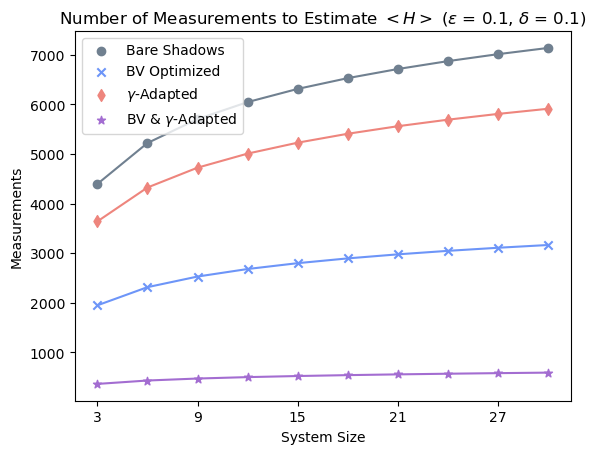

In [21]:
from matplotlib.ticker import MaxNLocator

smax = 10
T = 1

oriMMTS = []
bvoptMMTS = []
adaptMMTS = []
bvoptadaptMMTS = []

for p in range(1,smax+1): #here we keep T constant and scale s_max
    oriMMTS.append(numberOfMeasurements(kLINK, kLINKop, 2, 2*p*(T+1)))
    bvoptMMTS.append(numberOfMeasurements(kLINK_optimized, kLINKop, 2, 2*p*(T+1)))
    adaptMMTS.append(numberOfMeasurements_weighted(kfromupdatedpdf_LINK, pdffullVb_LINK, kLINKop, 2, 2*p*(T+1)))
    bvoptadaptMMTS.append(numberOfMeasurements_weighted(kfromupdatedpdf_LINK_postBV, pdffullVb_LINK_postBV, kLINKop, 2, 2*p*(T+1)))

syssizeset = range((T+2),(smax+1)*(T+2),3)
plt.scatter(syssizeset,oriMMTS,label='Bare Shadows',color='slategrey',marker= 'o')
plt.plot(syssizeset,oriMMTS,'slategrey')
plt.scatter(syssizeset,bvoptMMTS,label='BV Optimized',color='#6D95F8',marker= 'x')
plt.plot(syssizeset,bvoptMMTS,'#6D95F8')
plt.scatter(syssizeset,adaptMMTS,label='$\gamma$-Adapted',color='#EE857D',marker= 'd')
plt.plot(syssizeset,adaptMMTS,'#EE857D')
plt.scatter(syssizeset,bvoptadaptMMTS,label='BV & $\gamma$-Adapted',color='#A36DD1',marker= '*')
plt.plot(syssizeset,bvoptadaptMMTS,'#A36DD1')

plt.legend()
plt.xlabel('System Size')
plt.ylabel('Measurements')
plt.title('Number of Measurements to Estimate $<H>$ ($\epsilon$ = {}, $\delta$ = {})'.format(EPSILON, DELTA))
# plt.yscale("log")
syssetticks = range(3,(smax+1)*3,6)
plt.xticks(syssetticks,syssetticks)
plt.show()

# Generating Figure 3b

In [22]:
#GLOBAL VARIABLES FOR FIGURE 3(b)
DELTA=0.1
EPSILON = 0.1
termsInHam = 1
su2nitaries = discretize_su2(25)

#Making Global Variables to Create Faster Functions 
systemsize = 2
bblist = makeBBlist(systemsize)
bsAcrossV = bblist*len(su2nitaries)
(su2tensorn,su2tensornH) = tensorVersionSU2nitaries(systemsize)
tensornAcrossb = np.repeat(su2tensorn,2**systemsize,0)
tensornAcrossbH = np.repeat(su2tensornH,2**systemsize,0)
VbbVvector = constructVBBVvector() # construct vector of VbbVs

#Make generic, uniform probability distribution over the set of unitaries
uniformPDFLINK = np.ones(len(su2nitaries)*2**systemsize)
uniformPDFLINK = np.multiply(1/(len(su2nitaries)*2**systemsize), uniformPDFLINK)

#Biases to consider
testlam = [0.000000000000001,0.000000000000005,0.00000000000001,0.0000000000001,0.000000000001,0.00000000001,0.0000000001,0.000000001, 0.00000001,0.0000001,0.000001, 0.00001,0.0001,0.001,0.01,0.05,0.1,0.2]

### 10,000 Measurements

In [23]:
NUMMMTS=10000

# Calculate the bias and precision (precision using max variance and bernsteins)
biasLINK10000 = []
precisionLINK10000 = []
for lam in testlam:
    kveclam = getBiasedShadowkop(kLINKop, lam)
    biasLINK10000.append(linalg.norm(makeOfromkVb(kveclam, 2)-kLINKop))
    precisionLINK10000.append(precisionHS_general(kveclam, uniformPDFLINK, kLINKop, 2, termsInHam))

### 7,500 Measurements

In [24]:
NUMMMTS=7500

# Calculate the bias and precision (precision using max variance and bernsteins)
biasLINK7500 = []
precisionLINK7500 = []
for lam in testlam:
    kveclam = getBiasedShadowkop(kLINKop, lam)
    biasLINK7500.append(linalg.norm(makeOfromkVb(kveclam, 2)-kLINKop))
    precisionLINK7500.append(precisionHS_general(kveclam, uniformPDFLINK, kLINKop, 2, termsInHam))

### 5,000 Measurements

In [25]:
NUMMMTS=5000

# Calculate the bias and precision (precision using max variance and bernsteins)
biasLINK5000 = []
precisionLINK5000 = []
for lam in testlam:
    kveclam = getBiasedShadowkop(kLINKop, lam)
    biasLINK5000.append(linalg.norm(makeOfromkVb(kveclam, 2)-kLINKop))
    precisionLINK5000.append(precisionHS_general(kveclam, uniformPDFLINK, kLINKop, 2, termsInHam))

### Plot Results

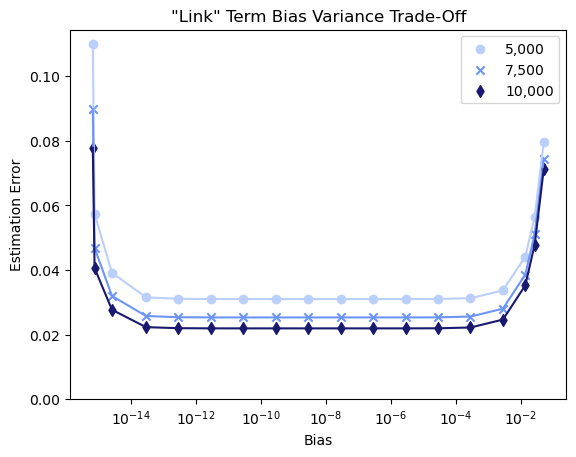

In [26]:
plt.plot(biasLINK5000,precisionLINK5000, color = '#BBCFFB')
plt.scatter(biasLINK5000,precisionLINK5000, color = '#BBCFFB', label='5,000', marker='o')

plt.plot(biasLINK7500,precisionLINK7500, color = '#6D95F8')
plt.scatter(biasLINK7500,precisionLINK7500, color = '#6D95F8', label='7,500', marker='x')

plt.plot(biasLINK10000,precisionLINK10000, color = 'midnightblue')
plt.scatter(biasLINK10000,precisionLINK10000, color = 'midnightblue', label='10,000', marker='d')

plt.xlabel('Bias')
plt.ylabel('Estimation Error') #estimation/prediction error
plt.title('"Link" Term Bias Variance Trade-Off')
plt.xscale("log")
ax = plt.gca()
ax.set_ylim(bottom = 0)
plt.margins(x=0.05)
plt.legend()
plt.show()